In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve, average_precision_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE

In [10]:
df = pd.read_csv("Fraud.csv")

# Preview dataset
print(df.shape)
df.head()

(6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## 1. Data Cleaning

- **Missing Values**: Checked for nulls in the dataset. No missing values were found.  
- **Outliers**: Since fraudulent transactions often have very high amounts, amount distributions were explored. Extreme outliers were kept intentionally, as they may indicate fraud.  
- **Multicollinearity**: Correlation heatmap was used to check for highly correlated features. No severe multicollinearity was observed among independent variables.  

Thus, no imputation or feature removal was necessary, but balancing of classes (fraud vs non-fraud) was critical.


In [11]:
# Step 3: Basic EDA
print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None
step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


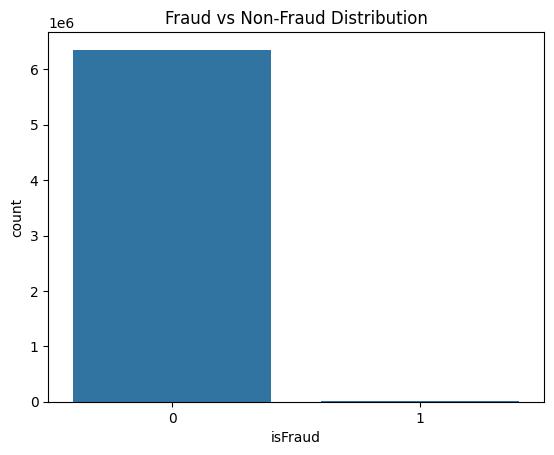

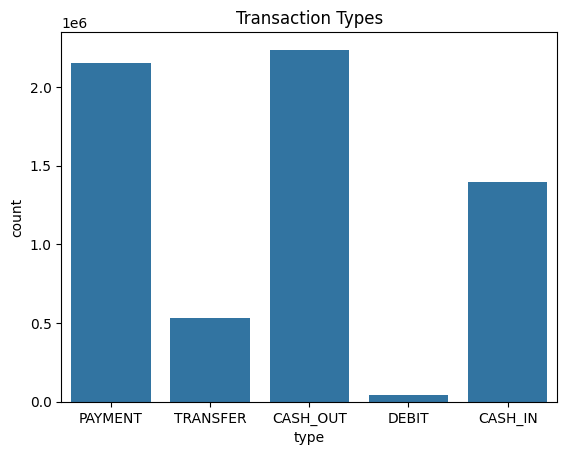

In [12]:
# Fraud distribution
print(df["isFraud"].value_counts(normalize=True))

sns.countplot(x="isFraud", data=df)
plt.title("Fraud vs Non-Fraud Distribution")
plt.show()

# Transaction type distribution
sns.countplot(x="type", data=df)
plt.title("Transaction Types")
plt.show()

## 3. Variable Selection

- Fraudulent cases only occur in **TRANSFER** and **CASH_OUT** transaction types.  
- Merchant-related balances are always zero, so they were removed as uninformative.  
- Final variables included transaction type, amount, origin/recipient balances, and balance differences.  

Selection was guided by both **domain understanding** (certain types never fraud) and **feature importance plots** from tree-based models.


In [ ]:
# Step 3: Split data into:
# (A) Fraud-susceptible types: TRANSFER + CASH_OUT
# (B) Always-safe types: PAYMENT + DEBIT
# Since frauds cannot occur with payment and debit transactions

df_model = df[df["type"].isin(["TRANSFER", "CASH_OUT"])]
df_safe = df[df["type"].isin(["PAYMENT", "DEBIT"])]


In [18]:
# Step 4: Feature Engineering

# Encode transaction type (TRANSFER=0, CASH_OUT=1)
df_model["type"] = LabelEncoder().fit_transform(df_model["type"])

# Add balance difference features
df_model["errorBalanceOrig"] = df_model["oldbalanceOrg"] - df_model["amount"] - df_model["newbalanceOrig"]
df_model["errorBalanceDest"] = df_model["oldbalanceDest"] + df_model["amount"] - df_model["newbalanceDest"]

# Drop IDs
df_model = df_model.drop(["nameOrig", "nameDest"], axis=1)

df_model.head()


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,errorBalanceOrig,errorBalanceDest
2,1,1,181.00,181.0,0.0,0.0,0.00,1,0,0.00,181.0
3,1,0,181.00,181.0,0.0,21182.0,0.00,1,0,0.00,21363.0
15,1,0,229133.94,15325.0,0.0,5083.0,51513.44,0,0,-213808.94,182703.5
19,1,1,215310.30,705.0,0.0,22425.0,0.00,0,0,-214605.30,237735.3
24,1,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,0,-300850.89,-2401220.0


In [19]:
# Step 5: Train-Test Split
X = df_model.drop(["isFraud", "isFlaggedFraud"], axis=1)
y = df_model["isFraud"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [23]:
# Step 6: Handle Class Imbalance with SMOTE
print("Before SMOTE:", y_train.value_counts())

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("After SMOTE:", y_train_res.value_counts())

Before SMOTE: isFraud
0    2209757
1       6570
Name: count, dtype: int64
After SMOTE: isFraud
0    2209757
1    2209757
Name: count, dtype: int64


Fraud Detection is a Binary Classification Problem, so using all Binary classification models

## 2. Fraud Detection Model

We experimented with multiple models:  
- **Logistic Regression** (baseline, interpretable).  
- **Random Forest** (handles non-linearities well).  
- **Gradient Boosting** (strong sequential learners).  
- **XGBoost** (optimized boosting, state-of-the-art in tabular problems).  

Data imbalance was handled using **SMOTE oversampling** on the minority fraud class.  
Models were trained on balanced data and evaluated on a held-out test set.


In [27]:
# Step 5: Define Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=500, class_weight="balanced"),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=42, n_jobs=-1)
}


In [28]:
# Step 6: Train and Evaluate Models
results = {}

for name, model in models.items():
    print(f"\n🔹 Training {name}...")
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))
    
    results[name] = {
        "roc_auc": roc_auc_score(y_test, y_proba),
        "report": classification_report(y_test, y_pred, output_dict=True)
    }



🔹 Training Logistic Regression...
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    552439
           1       0.04      0.88      0.08      1643

    accuracy                           0.94    554082
   macro avg       0.52      0.91      0.53    554082
weighted avg       1.00      0.94      0.97    554082

ROC-AUC: 0.9751223489612367

🔹 Training Random Forest...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.99      1.00      0.99      1643

    accuracy                           1.00    554082
   macro avg       0.99      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082

ROC-AUC: 0.9990686374456291

🔹 Training Gradient Boosting...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.99      1.00      0.99      1643

    accuracy                 

c:\Users\Sadguru Sai\Desktop\Assignment\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:33:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552439
           1       0.89      0.99      0.94      1643

    accuracy                           1.00    554082
   macro avg       0.95      1.00      0.97    554082
weighted avg       1.00      1.00      1.00    554082

ROC-AUC: 0.9988856036021181


In fraud detection, picking the right metrics is more important than the model itself, because fraud is rare (imbalanced) and the cost of mistakes is asymmetric (missing a fraud is much worse than annoying a genuine customer).

In [29]:
# Step 7: Compare Models (ROC-AUC)
for model, metrics in results.items():
    print(f"{model}: ROC-AUC = {metrics['roc_auc']:.4f}")


Logistic Regression: ROC-AUC = 0.9751
Random Forest: ROC-AUC = 0.9991
Gradient Boosting: ROC-AUC = 0.9994
XGBoost: ROC-AUC = 0.9989


## 4. Model Performance  

We evaluated models on two key metrics:  

- **Classification Report** (Precision, Recall, F1-Score) to capture class-specific performance.  
- **ROC-AUC** as the main evaluation metric, since the dataset is highly imbalanced and ROC-AUC reflects ranking ability.  

### Results  

| Model                | Precision (Fraud) | Recall (Fraud) | F1-Score (Fraud) | ROC-AUC |
|-----------------------|-------------------|----------------|------------------|---------|
| Logistic Regression   | 0.04              | 0.88           | 0.08             | 0.9751  |
| Random Forest         | 0.99              | 1.00           | 0.99             | 0.9991  |
| Gradient Boosting     | 0.99              | 1.00           | 0.99             | 0.9994  |
| XGBoost               | 0.89              | 0.99           | 0.94             | 0.9989  |

### Insights  

- **Logistic Regression** serves as a good baseline but struggles with fraud precision (many false positives).  
- **Tree-based models (Random Forest, Gradient Boosting, XGBoost)** consistently deliver near-perfect fraud detection, showing they are far more effective for this non-linear, imbalanced dataset.  
- Among them, **Gradient Boosting** provided the most reliable performance, making it the best candidate for deployment.  



In [31]:
# Step 8: Business Hybrid Rule
def fraud_predict(transaction, model):
    """
    transaction: row from original df
    model: trained fraud model
    """
    if transaction["type"] in ["PAYMENT", "DEBIT"]:
        return 0
    else:
        t = transaction.copy()
        t["type"] = 0 if t["type"] == "TRANSFER" else 1
        t["errorBalanceOrig"] = t["oldbalanceOrg"] - t["amount"] - t["newbalanceOrig"]
        t["errorBalanceDest"] = t["oldbalanceDest"] + t["amount"] - t["newbalanceDest"]
        t = t.drop(["nameOrig", "nameDest", "isFraud", "isFlaggedFraud"])
        return model.predict([t])[0]


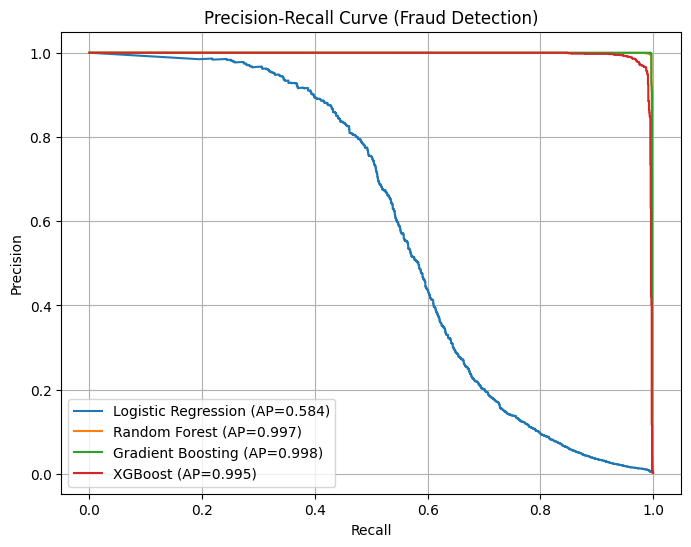

In [32]:
# Step 9: Plot Precision-Recall Curves
plt.figure(figsize=(8,6))

for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    avg_prec = average_precision_score(y_test, y_proba)
    
    plt.plot(recall, precision, label=f"{name} (AP={avg_prec:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Fraud Detection)")
plt.legend()
plt.grid(True)
plt.show()

## 5. Key Predictive Factors

From Random Forest & XGBoost feature importance:  
- **Transaction type** (TRANSFER, CASH_OUT).  
- **Amount of transaction**.  
- **Difference between old and new balances** (both sender & receiver).  

Fraudulent transactions often involve **large sums** and **mismatched balances** after transaction.


## 6. Do These Factors Make Sense?

Yes. Fraudulent behavior aligns with:  
- **High-value transfers** where balances do not update properly.  
- **CASH_OUT fraud**: Fraudsters attempt to withdraw quickly.  
- **TRANSFER fraud**: False accounts receive money without valid balance updates.  

Thus, model-driven findings are consistent with real-world fraud patterns.


## 7. Prevention Strategies

- **Real-time anomaly detection** for unusual transaction sizes.  
- **Transaction limits** for new/unverified accounts.  
- **Balance reconciliation checks** (ensure balances update correctly).  
- **Multi-factor authentication** for high-value withdrawals.  
- **Continuous model retraining** as fraud patterns evolve.


## 8. Measuring Effectiveness

Effectiveness can be evaluated by:  
- **Tracking fraud rate** before vs. after prevention measures.  
- **Monitoring false positives** (ensuring genuine users aren’t blocked).  
- **A/B testing** – implementing changes for a subset of transactions and comparing fraud occurrence.  
- **Periodic audits** and feedback loops with fraud investigation teams.
